In [ ]:
import re
import nltk
import string

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords, wordnet

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Представление и предобработка текстовых данных 

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str)`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [ ]:
#происходит инициализация трех объектов, которые будут использоваться для обработки текстовых данных в задачах обработки естественного языка
punctuation = set(string.punctuation)
stop_words = set(stopwords.words("english"))
lemmatizer = nltk.WordNetLemmatizer()

In [ ]:
#Функция для трансляции имен с nltk в wordnet
def custom_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    
    tags_router = {
     'CD': wordnet.NOUN,
     'JJ': wordnet.ADJ, 
     'JJS': wordnet.ADJ, 
     'MD' : wordnet.NOUN,
     'NN': wordnet.NOUN,
     'NNS': wordnet.NOUN,
     'RB': wordnet.ADV,
     'VB' : wordnet.VERB,
     'VBD': wordnet.VERB,
     'VBG': wordnet.VERB,
     'VBN': wordnet.VERB,
     'VBZ': wordnet.VERB,
    }
    
    return tags_router.get(tag, wordnet.NOUN)

In [ ]:
def preprocess_text(text: str) -> str:
    re_pattern = r'[^a-zA-Z0-9.,!?\s]'
    text = text.lower()
    items = re.sub(string = text, pattern = re_pattern, repl = '')
    
    sentences = []
    for sentence in nltk.sent_tokenize(text):
        words = []
        for word in nltk.word_tokenize(sentence):
            if word not in stop_words and word not in punctuation:
                lemma = lemmatizer.lemmatize(word, pos=custom_pos(word))
                words.append(lemma)
        sentences.append(" ".join(words))
    text = ". ".join(sentences)
    return text

In [ ]:
preprocess_text(text)

'select preference run install command. stable represent currently test support version pytorch. note libtorch available c++'

In [ ]:
preprocess_text("Ploho & Молчат дома - По краю острова [2019].")

'ploho молчат дома по краю острова 2019'

1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [ ]:
processed_item = preprocess_text(text)
processed_item

'select preference run install command. stable represent currently test support version pytorch. note libtorch available c++'

In [ ]:
#Получаем все слова для нашего алфавита
alphabet = list(set(nltk.word_tokenize(processed_item)) | set(".")) 
alphabet

['select',
 'install',
 'currently',
 'preference',
 'note',
 'support',
 'stable',
 'libtorch',
 'pytorch',
 'c++',
 'test',
 'available',
 'represent',
 'command',
 'run',
 '.',
 'version']

In [ ]:
word_to_idx = {word: i for i, word in enumerate(alphabet)}
word_to_idx

{'select': 0,
 'install': 1,
 'currently': 2,
 'preference': 3,
 'note': 4,
 'support': 5,
 'stable': 6,
 'libtorch': 7,
 'pytorch': 8,
 'c++': 9,
 'test': 10,
 'available': 11,
 'represent': 12,
 'command': 13,
 'run': 14,
 '.': 15,
 'version': 16}

In [ ]:
#Берем только первое предложение
sentence = nltk.sent_tokenize(processed_item)[0]
sentence

'select preference run install command.'

In [ ]:
#Заполняем тензор нулями на длинну нашего алфавита
res_tensor = torch.zeros(len(alphabet))
res_tensor

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
#Получаем индекы распознанных слов
word_indices = [word_to_idx[w] for w in nltk.word_tokenize(sentence)]
word_indices

[0, 3, 14, 1, 13, 15]

In [ ]:
#Где есть индексы - проставляем 1 и 
res_tensor[word_indices] = 1
res_tensor

tensor([1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])

## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [ ]:
#2.1 Считать файл surnames/surnames.csv.
import pandas as pd
df = pd.read_csv("./surnames.csv")
df

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian
...,...,...
10975,Quraishi,Arabic
10976,Innalls,English
10977,Król,Polish
10978,Purvis,English


In [ ]:
#2.2 Закодировать национальности числами, начиная с 0.
nationalities = df["nationality"].unique() #возвращаем массив всех уникальных значений
nationalities

array(['English', 'French', 'Arabic', 'Russian', 'Japanese', 'Chinese',
       'Italian', 'Czech', 'Irish', 'German', 'Greek', 'Spanish',
       'Polish', 'Dutch', 'Vietnamese', 'Korean', 'Portuguese',
       'Scottish'], dtype=object)

In [ ]:
#создаем словарь vocab_nat, который отображает каждую уникальную национальность из массива nationalities в уникальный номер, сгенерированный с помощью функции enumerate()
vocab_nat = {item: number for number, item in enumerate(nationalities)}
vocab_nat

{'English': 0,
 'French': 1,
 'Arabic': 2,
 'Russian': 3,
 'Japanese': 4,
 'Chinese': 5,
 'Italian': 6,
 'Czech': 7,
 'Irish': 8,
 'German': 9,
 'Greek': 10,
 'Spanish': 11,
 'Polish': 12,
 'Dutch': 13,
 'Vietnamese': 14,
 'Korean': 15,
 'Portuguese': 16,
 'Scottish': 17}

In [ ]:
reverse_nat = {number: item for number, item in enumerate(nationalities)}
reverse_nat

{0: 'English',
 1: 'French',
 2: 'Arabic',
 3: 'Russian',
 4: 'Japanese',
 5: 'Chinese',
 6: 'Italian',
 7: 'Czech',
 8: 'Irish',
 9: 'German',
 10: 'Greek',
 11: 'Spanish',
 12: 'Polish',
 13: 'Dutch',
 14: 'Vietnamese',
 15: 'Korean',
 16: 'Portuguese',
 17: 'Scottish'}

In [ ]:
#создаем новый столбец "label" в объекте df, который является результатом применения метода map() к столбцу "nationality" с использованием словаря vocab_nat
df["label"] = df["nationality"].map(vocab_nat)
df

,surname,nationality,label
0,Woodford,English,0
1,Coté,French,1
2,Kore,English,0
3,Koury,Arabic,2
4,Lebzak,Russian,3
...,...,...,...
10975,Quraishi,Arabic,2
10976,Innalls,English,0
10977,Król,Polish,12
10978,Purvis,English,0


In [ ]:
targets=torch.tensor(df["label"], dtype=torch.long)
targets

tensor([ 0,  1,  0,  ..., 12,  0,  9])

In [ ]:
#2.4 Реализовать класс Vocab (токен = символ)
#создаем класс Vocab, который является реализацией словаря для предобработки и работы с текстовыми данными
class Vocab:
  def __init__(self, data):
    #создаем объект класса, создаются два пустых словаря idx_to_token и token_to_idx, а также определяется длина словаря (vocab_len) инициализацией ее значением len(self.token_to_idx)
    self.idx_to_token = {}
    self.token_to_idx = {}
    self.gennerate_vocab(data) 
    self.vocab_len = len(self.token_to_idx)

  def add_token(self, token):
    #добавляет новый токен в словарь, если он еще не был добавлен,а если токен уже есть в словаре, то метод ничего не делает
        if token not in self.token_to_idx:
            self.token_to_idx[token] = len(self.token_to_idx)
            self.idx_to_token[len(self.idx_to_token)] = token
            
  def gennerate_vocab(self, data):
    #заполняет словарь на основе входных данных
    #он проходится по каждой фамилии в массиве data и каждому символу в ней
    #после этого он вызывает метод add_token для каждого символа, чтобы добавить его в словарь
       for surname in data:
           for char in preprocess_text(surname):
               self.add_token(char)

In [ ]:
#создаем массив уникальных значений фамилий из столбца "surname" объекта df и преобразует его в массив строковых значений с помощью методов unique() и astype('str').
data = df["surname"].unique().astype('str')
data

array(['Woodford', 'Coté', 'Kore', ..., 'Król', 'Purvis', 'Messerli'],
      dtype='<U17')

In [ ]:
#создаем объект класса Vocab, используя массив data
vocab = Vocab(data)
vocab.idx_to_token #это словарь, который содержит соответствие между индексами и токенами словаря

{0: 'w',
 1: 'o',
 2: 'd',
 3: 'f',
 4: 'r',
 5: 'c',
 6: 't',
 7: 'é',
 8: 'k',
 9: 'e',
 10: 'u',
 11: 'y',
 12: 'l',
 13: 'b',
 14: 'z',
 15: 'a',
 16: 'i',
 17: 'n',
 18: 'h',
 19: 'm',
 20: 's',
 21: 'v',
 22: 'p',
 23: 'g',
 24: 'j',
 25: "'",
 26: 'q',
 27: 'à',
 28: 'x',
 29: 'ü',
 30: '-',
 31: 'í',
 32: 'ú',
 33: 'ä',
 34: 'ö',
 35: 'ó',
 36: '1',
 37: 'ò',
 38: 'ñ',
 39: 'ż',
 40: 'ß',
 41: 'á',
 42: 'è',
 43: 'ã',
 44: 'ê',
 45: 'ì',
 46: 'ś',
 47: 'ń',
 48: 'ù',
 49: 'ç',
 50: '/',
 51: 'õ',
 52: 'ą',
 53: 'ł'}

In [ ]:
vocab.token_to_idx #это словарь, который содержит соответствие между токенами словаря и их индексами

{'w': 0,
 'o': 1,
 'd': 2,
 'f': 3,
 'r': 4,
 'c': 5,
 't': 6,
 'é': 7,
 'k': 8,
 'e': 9,
 'u': 10,
 'y': 11,
 'l': 12,
 'b': 13,
 'z': 14,
 'a': 15,
 'i': 16,
 'n': 17,
 'h': 18,
 'm': 19,
 's': 20,
 'v': 21,
 'p': 22,
 'g': 23,
 'j': 24,
 "'": 25,
 'q': 26,
 'à': 27,
 'x': 28,
 'ü': 29,
 '-': 30,
 'í': 31,
 'ú': 32,
 'ä': 33,
 'ö': 34,
 'ó': 35,
 '1': 36,
 'ò': 37,
 'ñ': 38,
 'ż': 39,
 'ß': 40,
 'á': 41,
 'è': 42,
 'ã': 43,
 'ê': 44,
 'ì': 45,
 'ś': 46,
 'ń': 47,
 'ù': 48,
 'ç': 49,
 '/': 50,
 'õ': 51,
 'ą': 52,
 'ł': 53}

In [ ]:
#2.5 Реализовать класс SurnamesDataset
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
class SurnamesDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, surname):
    '''Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2)'''
    repr = torch.zeros(self.vocab.vocab_len)
    for char in preprocess_text(surname):
        idx = self.vocab.token_to_idx[char]
        repr[idx] = 1
    return repr

  def __len__(self) -> int: #это метод, который возвращает количество элементов в датасете
    return len(self.X)

  def __getitem__(self, idx) -> tuple: #это метод, который принимает индекс элемент в датасете и возвращает кортеж из бинарного представления фамилии и соответствующей метки класса
    return self.vectorize(self.X[idx]), targets[idx]

  def __str__(self) -> str: #это метод, который возвращает строковое представление объекта класса
    return f"SurnamesDataset with {self.__len__()} items"
    
  def y_len(self) -> int: #это метод, который возвращает количество уникальных меток классов в массиве y
    return self.y.unique().shape[0]

In [ ]:
#2.3 Разбить датасет на обучающую и тестовую выборку
dataset = SurnamesDataset(
    df["surname"].tolist(),
    torch.tensor(df["label"], dtype=torch.long),
    vocab,
)


print(dataset)


train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, pin_memory = True)

print(f"train_size : {train_size}")
print(f"test_size : {test_size}")

SurnamesDataset with 10980 items
train_size : 8784
test_size : 2196


In [ ]:
dataset.__getitem__(0)

(tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor(0))

In [ ]:
dataset.__getitem__(1)

(tensor([0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor(1))

In [ ]:
#2.6. Обучить классификатор.
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_sum = 0
    for batch, (X, y) in enumerate(dataloader):

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss
        if batch % 300 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    return loss_sum / len(dataloader)


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, out_features):
        super(NeuralNetwork, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, inputs):
        return self.seq(inputs)

In [ ]:
model = NeuralNetwork(vocab.vocab_len, dataset.y_len())
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_dataloader = DataLoader(train_dataset, batch_size=10)
test_dataloader = DataLoader(test_dataset, batch_size=10)

In [ ]:
losses_plt = []

epochs = 40
losses = torch.empty(epochs)


for t in range(epochs): 
    print(f"Epoch {t+1}\n-------------------------------")
    buf = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses[t] = buf
    losses_plt.append(buf.item())
    test_loop(test_dataloader, model, loss_fn)
    
print("Готов")

Epoch 1
-------------------------------
loss: 2.902743  [    0/ 8784]
loss: 2.047071  [ 3000/ 8784]
loss: 1.825141  [ 6000/ 8784]
Test Error: 
 Accuracy: 45.3%, Avg loss: 1.945435 

Epoch 2
-------------------------------
loss: 2.367048  [    0/ 8784]
loss: 1.605566  [ 3000/ 8784]
loss: 1.433642  [ 6000/ 8784]
Test Error: 
 Accuracy: 48.7%, Avg loss: 1.760632 

Epoch 3
-------------------------------
loss: 2.068310  [    0/ 8784]
loss: 1.438187  [ 3000/ 8784]
loss: 1.279078  [ 6000/ 8784]
Test Error: 
 Accuracy: 50.0%, Avg loss: 1.670972 

Epoch 4
-------------------------------
loss: 1.942110  [    0/ 8784]
loss: 1.373446  [ 3000/ 8784]
loss: 1.204539  [ 6000/ 8784]
Test Error: 
 Accuracy: 51.1%, Avg loss: 1.614071 

Epoch 5
-------------------------------
loss: 1.873549  [    0/ 8784]
loss: 1.344648  [ 3000/ 8784]
loss: 1.161591  [ 6000/ 8784]
Test Error: 
 Accuracy: 51.7%, Avg loss: 1.572790 

Epoch 6
-------------------------------
loss: 1.827068  [    0/ 8784]
loss: 1.329300  [ 30

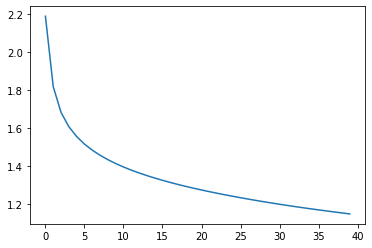

In [ ]:
#2.7 Измерить точность на тестовой выборке. 
import matplotlib.pyplot as plt
plt.plot(torch.arange(len(losses_plt)), losses_plt)

In [ ]:
test_loop(dataloader=test_dataloader, model=model, loss_fn=loss_fn);

Test Error: 
 Accuracy: 61.3%, Avg loss: 1.258848 



In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = model(inputs)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) 
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

In [ ]:
names_list = [
    "Demenchuk",
    "Baranov",
    "Fogel",
    "Newman"
]

targets_list = ["Russian","Russian", "German", "English"]

for name, target in zip(names_list, targets_list):
    
    x_test, y_test = dataset.vectorize(name), target
    predict = model(x_test.unsqueeze(0))
    pred_proba, pred_label_indices = nn.functional.softmax(predict, 1).topk(3, dim=1)
    pred_labels = [nationalities[i.item()] for i in pred_label_indices.squeeze()]
    
    predicts_dict = {predict_item : round(score.item(),4) for predict_item, score in zip(pred_labels, pred_proba[0])}
    print(f"Surname : {name}")
    print(f"True    : {target}")
    
    print(f"Predicts: {predicts_dict}\n")

Surname : Demenchuk
True    : Russian
Predicts: {'Russian': 0.3518, 'German': 0.2548, 'Dutch': 0.1564}

Surname : Baranov
True    : Russian
Predicts: {'Russian': 0.5977, 'Italian': 0.1447, 'English': 0.0938}

Surname : Fogel
True    : German
Predicts: {'English': 0.5822, 'German': 0.1611, 'Russian': 0.0824}

Surname : Newman
True    : English
Predicts: {'English': 0.595, 'German': 0.1169, 'Arabic': 0.0987}



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(vocab_nat.keys())))

              precision    recall  f1-score   support

     English       0.54      0.80      0.64       586
      French       0.00      0.00      0.00        44
      Arabic       0.73      0.96      0.83       309
     Russian       0.77      0.75      0.76       488
    Japanese       0.47      0.50      0.49       152
     Chinese       0.38      0.47      0.42        34
     Italian       0.49      0.42      0.45       129
       Czech       0.33      0.03      0.06        89
       Irish       0.62      0.20      0.30        41
      German       0.50      0.28      0.36       112
       Greek       0.64      0.29      0.40        31
     Spanish       0.58      0.24      0.34        58
      Polish       0.58      0.32      0.41        22
       Dutch       0.50      0.03      0.05        40
  Vietnamese       0.00      0.00      0.00        10
      Korean       1.00      0.06      0.11        18
  Portuguese       0.00      0.00      0.00        17
    Scottish       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


In [ ]:
#3.1 Считать файл yelp/raw_train.csv. Оставить от исходного датасета 10% строчек.
df = pd.read_csv("raw_train.csv", names=["index", "review"])
df.shape

(560000, 2)

In [ ]:
df

,index,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


In [ ]:
df = df.sample(frac=0.1, ignore_index=True, random_state=0)
df.shape

(56000, 2)

In [ ]:
df

,index,review
0,2,"Call me crazy, but I really enjoyed this place..."
1,1,"HORRIBLE, HORRIBLE, HORRIBLE ONLINE CUSTOMER S..."
2,2,The staff were extremely helpful in answering ...
3,2,The steak tartare is fantastic! I'd come back...
4,2,Everything I could want for $3.
...,...,...
55995,2,Wow! I never thought I would find a place like...
55996,2,Awesome walk in place for a bite to eat. You ...
55997,2,What a beautiful show! I jumped at the opportu...
55998,2,"In the lobby of the Hard Rock Hotel, this plac..."


In [ ]:
#3.2 Закодировать рейтинг числами, начиная с 0.
rating = {1: 0, 2: 1}
# Заменяем 1 на 0, а 2 на 1
df["index"] = df["index"].map(rating)
df

,index,review
0,1,"Call me crazy, but I really enjoyed this place..."
1,0,"HORRIBLE, HORRIBLE, HORRIBLE ONLINE CUSTOMER S..."
2,1,The staff were extremely helpful in answering ...
3,1,The steak tartare is fantastic! I'd come back...
4,1,Everything I could want for $3.
...,...,...
55995,1,Wow! I never thought I would find a place like...
55996,1,Awesome walk in place for a bite to eat. You ...
55997,1,What a beautiful show! I jumped at the opportu...
55998,1,"In the lobby of the Hard Rock Hotel, this plac..."


In [ ]:
df["review"] = df["review"].map(preprocess_text)
df

,index,review
0,1,call crazy really enjoy place. get ton food de...
1,0,horrible horrible horrible online customer ser...
2,1,staff extremely helpful answer question. take ...
3,1,steak tartare fantastic. 'd come back vega din...
4,1,everything could want 3
...,...,...
55995,1,wow. never thought would find place like sleep...
55996,1,awesome walk place bite eat. order counter bri...
55997,1,beautiful show. jumped opportunity see show ti...
55998,1,lobby hard rock hotel place trendy chic meet b...


In [ ]:
#3.4 Реализовать класс Vocab (токен = слово)
class Vocab:
    def __init__(self, data):
        self.tokens = list({ch for row in data for ch in row.split(" ")})
        self.idx_to_token = {idx: token for idx, token in enumerate(self.tokens)}
        self.token_to_idx = {token: idx  for idx, token in enumerate(self.tokens)}
        self.vocab_len = len(self.idx_to_token)
        
    def __repr__(self) -> str:
        return f"Vocab with {self.vocab_len} tokens"

In [ ]:
vocab = Vocab(df["review"])
vocab

Vocab with 140173 tokens

In [ ]:
#3.5 Реализовать класс ReviewDataset
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, review):
        '''Генерирует представление отзыва review при помощи бинарного кодирования'''
        indices = [self.vocab.token_to_idx[el] for el in review.split(" ")]
        review_t = torch.zeros(self.vocab.vocab_len)
        review_t[indices] = 1
        return review_t

    def len_y_unique(self):
        return self.y.unique().size()[0]
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X[idx]), self.y[idx]

In [ ]:
review_dataset = ReviewDataset(
    df["review"].tolist(),
    torch.tensor(df["index"], dtype=torch.long),
    vocab,
)

len(review_dataset)

56000

In [ ]:
review_dataset[1]

(tensor([1., 0., 0.,  ..., 0., 0., 0.]), tensor(0))

In [ ]:
#3.3 Разбить датасет на обучающую и тестовую выборку
train_size = round(0.8 * len(review_dataset))
test_size = len(review_dataset) - train_size
train_dataset, test_dataset = random_split(review_dataset, lengths=(train_size, test_size))

print(f"Train dataset: {len(train_dataset)}")
print(f"Test dataset: {len(test_dataset)}")

Train dataset: 44800
Test dataset: 11200


In [ ]:
#3.6 Обучить классификатор
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, out_features):
        super(NeuralNetwork, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, out_features),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, inputs):
        return self.seq(inputs)

In [ ]:
model = NeuralNetwork(vocab.vocab_len, review_dataset.len_y_unique())

loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

print(model)

NeuralNetwork(
  (seq): Sequential(
    (0): Linear(in_features=140173, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=2, bias=True)
    (4): LogSoftmax(dim=1)
  )
)


In [ ]:
def train_loop(
        dataloader,
        model,
        loss_fn,
        optimizer,
        verbose = 100,
        device = "cpu",
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return avg_loss / num_batches

In [ ]:
losses_plt = []

epochs = 5
losses = torch.empty(epochs)
for t in range(epochs): 
    print(f"Epoch {t+1}\n-------------------------------")
    
    buf = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses[t] = buf
    losses_plt.append(buf.item())
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.696374  [    0/44800]
loss: 0.371221  [ 6400/44800]
loss: 0.272881  [12800/44800]
loss: 0.230120  [19200/44800]
loss: 0.101124  [25600/44800]
loss: 0.198495  [32000/44800]
loss: 0.207358  [38400/44800]
Test Error: 
 Accuracy: 90.7%, Avg loss: 0.231802 

Epoch 2
-------------------------------
loss: 0.306112  [    0/44800]
loss: 0.186483  [ 6400/44800]
loss: 0.113331  [12800/44800]
loss: 0.043725  [19200/44800]
loss: 0.020456  [25600/44800]
loss: 0.096568  [32000/44800]
loss: 0.077546  [38400/44800]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.248453 

Epoch 3
-------------------------------
loss: 0.091133  [    0/44800]
loss: 0.070410  [ 6400/44800]
loss: 0.035730  [12800/44800]
loss: 0.016254  [19200/44800]
loss: 0.007623  [25600/44800]
loss: 0.042859  [32000/44800]
loss: 0.018592  [38400/44800]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.299159 

Epoch 4
-------------------------------
loss: 0.030775  [    0/44800]
loss: 0.018451  [ 6400/4

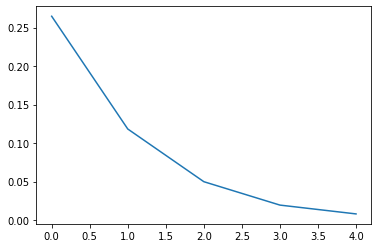

In [ ]:
#3.7 Измерить точность на тестовой выборке. 
import matplotlib.pyplot as plt
plt.plot(torch.arange(len(losses_plt)), losses_plt)

In [ ]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.428984 



In [ ]:
y_pred = []
y_true = []

for inputs, labels in test_dataloader:
        output = model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

In [ ]:
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5670
    Positive       0.90      0.90      0.90      5530

    accuracy                           0.90     11200
   macro avg       0.90      0.90      0.90     11200
weighted avg       0.90      0.90      0.90     11200



In [ ]:
names_list = [
"I was here 2 weeks ago. The staff was sociable and recommended the dish of the day to me. Everything was excellent",
"I absolutely did not like this service. The meat was cold. I asked to redo it, but it already spoiled my mood"
 ]

targets_list = ["Positive", "Negative"]
targets_dict = {1:"Positive", 0: "Negative"}

for name, target in zip(names_list, targets_list):

    x_test, y_test = review_dataset.vectorize(preprocess_text(name)), target
    predict = model(x_test.unsqueeze(0))
    pred_proba, pred_label_indices = nn.functional.softmax(predict, 1).topk(1, dim=1)
    
    res = pred_label_indices.squeeze()
    print(res)
    pred_labels = targets_dict[pred_label_indices.squeeze().item()]
    
    targets_list
    
    print(f"Review: \n{name}")
    print(f"True    : {target}")
    print(f"Predicts: {pred_labels}\n")

tensor(1)
Review: 
I was here 2 weeks ago. The staff was sociable and recommended the dish of the day to me. Everything was excellent
True    : Positive
Predicts: Positive

tensor(0)
Review: 
I absolutely did not like this service. The meat was cold. I asked to redo it, but it already spoiled my mood
True    : Negative
Predicts: Negative



In [ ]:
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5670
    Positive       0.90      0.90      0.90      5530

    accuracy                           0.90     11200
   macro avg       0.90      0.90      0.90     11200
weighted avg       0.90      0.90      0.90     11200

